# Importing libraries

In [1]:
import mesa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from mesa.visualization.modules import CanvasGrid, ChartModule
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import TextElement
from mesa.datacollection import DataCollector
import pandas as pd
import random

In [2]:
#global seed
# Set a global seed
global_seed = 100
random.seed(global_seed)
np.random.seed(global_seed)

In [3]:
class AgentCountElement(TextElement):
    def __init__(self):
        pass

    def render(self, model):
        corrupt_agents_count = model.schedule.get_type_count(Corrupt_agent)
        sugar_agents_count = model.schedule.get_type_count(Sugar)
        return f"Corrupt Agents: {corrupt_agents_count} | Sugar Agents: {sugar_agents_count}"

class AverageWealthElement(TextElement):
    def render(self, model):
        # Calculate the average wealth of alive corrupt agents
        corrupt_agents = [agent for agent in model.schedule.agents_by_type[Corrupt_agent].values()]
        if corrupt_agents:
            average_wealth = sum(agent.sugar_agent for agent in corrupt_agents) / len(corrupt_agents)
        else:
            average_wealth = 0
        return f"Average Wealth of Corrupt Agents: {average_wealth:.2f}"


In [4]:
# Helper functions

# Calculate the Euclidean distance between cells
def distance(dist1, dist2):
    x1, y1 = dist1
    x2, y2 = dist2
    dist_x = x1 - x2
    dist_y = y1 - y2

    dist = math.sqrt((dist_x ** 2) + (dist_y ** 2))
    return dist

In [5]:
#This is a class for sugar patches. Each sugar patch is treated as an agent
class Sugar(mesa.Agent):
    def __init__(self, unique_id, model, position, sugar_capacity):
        super().__init__(unique_id, model)
        self.position = position #position of sugar patche in the grid
        self.curr_amount = sugar_capacity #the current amount of sugar in a patch. Can be reduced if an agent eats the sugar
        self.sugar_capacity = sugar_capacity #maximum sugar for a patch
        self.step_counter = 0  # Counter for steps

    #The step function is going to add one of sugar per step until sugar is at its maximum capacity
    def step(self):
        self.curr_amount = min([self.sugar_capacity, self.curr_amount + 1])
        #self.curr_amount = min([self.sugar_capacity, 10])
        #print(self.unique_id, self.curr_amount, self.sugar_capacity)

In [6]:
#Class for corrupt agents
class Corrupt_agent(mesa.Agent):
    def __init__(self, unique_id, model, position, moore = False, sugar_agent = 0, sugar_metabolism = 0, sugar_vision = 0):
        super().__init__(unique_id, model)
        self.position = position #position of sugar patch in the grid
        self.moore = moore
        self.sugar_agent = sugar_agent
        self.sugar_metabolism = sugar_metabolism
        self.sugar_vision = sugar_vision
        self.shared_with_count = 0  # Counter for tracking sharing actions
        self.share_amount = 0
        self.steal_amount = 0 
        self.share_total = 0
        self.steal_total = 0 
        self.eat_total = 0 
        self.moved = False
        self.dead = False
        self.survival = 0

    #determines if the neigbouring cell is a sugar patch
    def is_sugar(self, position):
        cell = self.model.grid.get_cell_list_contents(position) # Gets the contents of a cell in a given position
        for agent in cell:
            if type(agent) is Sugar: # referes to the sugar class
                return agent
            return None
    
    # Get Sugar amount in the next cell
    def sugar_amount(self, position):
        sugar = self.is_sugar(position)
        if sugar:
            return sugar.curr_amount
        return 0

    def get_neighbours(self, position):
        '''
        This is a helper function for share_with_neighbours()
        '''
        cell = self.model.grid.get_cell_list_contents(position) # Gets the contents of a cell in a given position 
        
        for agent in cell:
            if isinstance(agent, Corrupt_agent): #if cell has corrupt agent
                return agent
    
    # the following function helps move() to determine if a cell has been occupied
    def cell_occupied(self, position):
        if position == self.position: # Agents are allowed to stay in the same position
           return False #not occupied
        # Now we cater for a situation in which a cell is occupied
        cell = self.model.grid.get_cell_list_contents(position) # Gets the contents of a cell in a given position
        for j in cell: #going through all neihgbourhoot cells
            if isinstance(j, Corrupt_agent): #if cell has corrupt agent
                return True
        return False

    # This function calculates welfares corrupt_agents
    def calculate_welfare(self, sugar):
        welfare = sugar/self.sugar_metabolism
        return welfare

    # This function calculates needs of corrupt_agents
    def calculate_need(self):
        need = self.sugar_agent/self.sugar_metabolism
        return need
    
    # This function etermines whether an agent is starved or not
    def starved(self):
        return (self.sugar_agent <= 0)

    def corrupt_share(self, other):
        '''
        This is a helper function for share_with_neighbours()
        Enables agents to share with others
        '''

        # Share with agents with sugar greater than 0           
        assert self.sugar_agent > 0
        assert other.sugar_agent > 0

        if self.sugar_agent > 10:
            if abs(self.sugar_agent - other.sugar_agent) <= 10 and other != self: # If wealth of agents is in the same 10 point radius
                self.share_amount = self.sugar_agent // 8 # we can share an 1/8 of our wealth
                self.sugar_agent -= self.share_amount
                other.sugar_agent += self.share_amount
                self.shared_with_count = self.shared_with_count + 1
                self.share_total += self.share_amount
                print(f"Agent {self.unique_id} with {self.sugar_agent} has shared {self.share_amount} with {other.unique_id} with {other.sugar_agent}")
                return
        #need_self = self.calculate_need()
        #need_other = other.calculate_need()
        #print(need_self, need_other)
       #     return

    def steal(self, other):
        '''
        This is a helper function for steal_from_neighbours()
        Enables agents to steal from others
        '''
        
        if other != self:
            self.steal_amount = min(other.sugar_agent // 8, 10)  # Steal up to 10 units or whatever the target has
            #self.steal_amount = 7   
            # Steal resources from the target
            other.sugar_agent -= self.steal_amount
            self.sugar_agent += self.steal_amount
            self.steal_total += self.steal_amount
            print(f"Agent {self.unique_id} stole {self.steal_amount} resources from Agent {other.unique_id}.")
            return
        
    # This function moves agents in the grid
    def move(self, exploration_prob=0.1):
        '''
        #1 Identify possible moves
        #2 Determine move that maximizes welfare
        #3 Find closest best option
        #4 Move
        '''
    
        #1 Identifying possible moves
        neighborhood = [i
                        for i in self.model.grid.get_neighborhood(self.position, self.moore, True, self.sugar_vision)
                        if not self.cell_occupied(i)  # Ensure that multiple corrupt agents are not in the same cell
                        ]
    
        # If the neighborhood is empty, return early
        if not neighborhood:
            return

        #2 Randomly decide whether to explore
        if self.random.random() < exploration_prob:
            # Exploration: Choose a random position from the neighborhood
            cell_final = [self.random.choice(neighborhood)]
        else:
            #3 Determine which neighbors provide maximum welfare
            welfare = [self.calculate_welfare(self.sugar_agent + self.sugar_amount(position)) for position in neighborhood]
            max_welfare = max(welfare)
    
            # Index of max welfare cells
            cell_indices = [i for i in range(len(welfare))
                            if math.isclose(welfare[i], max_welfare, rel_tol=1e-02)
                            ]
    
            # Converting indexes to cell positions
            cell_position = [neighborhood[i] for i in cell_indices]
    
            # Find the closest best option
            shortest_dist = min(distance(self.position, position) for position in cell_position)
            cell_final = [pos for pos in cell_position
                          if math.isclose(distance(self.pos, pos), shortest_dist, rel_tol=1e-02)
                          ]

        # If no valid move is found (e.g., all welfare values are equal), explore randomly
        if not cell_final or cell_final[0] == self.position:
            # Choose a random position from the neighborhood to ensure the agent moves
            cell_final = [self.random.choice(neighborhood)]
    
        self.random.shuffle(cell_final)  # Randomize choice if multiple equal options
    
        if cell_final[0] != self.position:
            self.moved = True
    
        #4 Move agent
        self.model.grid.move_agent(self, cell_final[0])
    
    #this function enables aents to cunsume sugar patches 
    def eat(self):
        sugar_patch = self.is_sugar(self.position)
        if sugar_patch:
            self.sugar_agent += sugar_patch.curr_amount
            self.eat_total += sugar_patch.curr_amount
            print(f"Agent {self.unique_id} has eaten {sugar_patch.curr_amount} sugar from sugar {sugar_patch.unique_id}")
            sugar_patch.curr_amount = 0

    def metabolize(self):
        self.sugar_agent -= self.sugar_metabolism

    # This function kills off agents who have usedup all their sugar
    def agent_die(self):
        if self.dead == False:
                self.survival+=1
        if self.starved():
            #print(self.unique_id, self.sugar_agent, self.model.schedule.get_type_count(Corrupt_agent))
            self.model.grid.remove_agent(self)
            self.model.schedule.remove(self)
            self.model.dead_agents += 1  # Increment the dead agents counter in the model
            self.dead = True
            print(f"Agent {self.unique_id} has died after {self.survival} steps")
            #print(self.unique_id, self.sugar_agent, self.model.schedule.get_type_count(Corrupt_agent))
        #elif not self.starved():
        #    print(self.unique_id, self.sugar_agent, self.sugar_vision, self.model.schedule.get_type_count(Corrupt_agent))
        
    #this is the function that corrupt agents will use to share resources
    def share_with_neighbours(self):    
        #Neighbors below help us create a list of agents we can share with
        ##get_neighbours() is ahelper function
        neighbors = [self.get_neighbours(position) for position in self.model.grid.get_neighborhood(self.position, self.moore, False, self.sugar_vision)
                    if self.cell_occupied(position)
                   ]

        if len(neighbors) == 0:
            return [],[] #return 2 empty lists if an agent doesn't have neighbors
        
        #iterate through neighbours and share (Favouritism)
        for i in neighbors:
            if i:
                self.corrupt_share(i)

    def steal_from_neighbours(self):
        # Find agents within the vision range
        target  = [self.get_neighbours(position) for position in self.model.grid.get_neighborhood(self.position, self.moore, False, self.sugar_vision)
                    if self.cell_occupied(position)
                   ]
        for i in target:
            if i:
                # Randomly select a target from the list
                #target = random.choice(potential_targets)
                self.steal(i)    
    

In [8]:
#This class belongs to the main model, the engine of the project.
class Model(mesa.Model):
    def __init__(self, X = 50, Y = 50, init_population = 100, init_resource_min = 10, init_resource_max = 20, metabolism_min = 1, metabolism_max = 5, vision_min = 1, vision_max = 5, seed=None):
        #grid-space width and height 
        self.X = X
        self.Y = Y

        # Set the global seed if provided
        if seed is not None:
            self.seed = seed
            random.seed(self.seed)
            np.random.seed(self.seed)

        #initializing population attributes
        self.init_population = init_population
        self.init_resource_min = init_resource_min
        self.init_resource_max = init_resource_max
        self.metabolism_min = metabolism_min
        self.metabolism_max = metabolism_max
        self.vision_min = vision_min
        self.vision_max = vision_max
        self.running = True
        self.dead_agents = 0
        self.cycle = 0

        #initiate mesa grid
        self.grid = mesa.space.MultiGrid(self.X, self.Y, torus = False)
        self.schedule = mesa.time.RandomActivationByType(self) #randomizes the sequence in which agents perform actions
        sugar_distro = np.genfromtxt("random.txt")   
        #plt.imshow(sugar_distro, origin = "lower") #Shows the grid

        # Initialize the DataCollector
        self.datacollector = mesa.DataCollector(
            model_reporters = {
                
                "Step": lambda model: model.schedule.steps,
                "Agents": lambda model: model.schedule.get_type_count(Corrupt_agent),
                "Average Wealth": lambda model: model.avg_wealth(),
            },

            agent_reporters = {
                "Unique ID": lambda agent: agent.unique_id if isinstance(agent, Corrupt_agent) else 0,
                "Wealth": lambda agent: agent.sugar_agent if isinstance(agent, Corrupt_agent) else 0,
                "Survival": lambda agent: agent.survival if isinstance(agent, Corrupt_agent) else 0,
                "Collection Efficiency": lambda agent: agent.sugar_vision if isinstance(agent, Corrupt_agent) else 0,
                "Consumption": lambda agent: agent.sugar_metabolism if isinstance(agent, Corrupt_agent) else 0,
                "Share Amount": lambda agent: agent.share_amount if isinstance(agent, Corrupt_agent) else 0,
                "Stolen Amount": lambda agent: agent.steal_amount if isinstance(agent, Corrupt_agent) else 0,
                "Moved": lambda agent: agent.moved if isinstance(agent, Corrupt_agent) else 0,
                "Total Stolen": lambda agent: agent.steal_total if isinstance(agent, Corrupt_agent) else 0,
                "Total Shared": lambda agent: agent.share_total if isinstance(agent, Corrupt_agent) else 0,
                "Total Eaten": lambda agent: agent.eat_total if isinstance(agent, Corrupt_agent) else 0,
            } 
        )
        
        #The for loop is used to create sugar agents in the grid
        all_agent_id = 0
        for _, (x,y) in self.grid.coord_iter():
            max_sugar = sugar_distro[x,y] #getting sugar levels from the sugar distribution
            if max_sugar > 0:
                sugar_agent = Sugar(all_agent_id, self, (x,y), max_sugar) #creating an a sugar agent
                self.grid.place_agent(sugar_agent, (x,y)) #places an agent in the grid wherever there is a sugar level greater than 0
                self.schedule.add(sugar_agent)
                #print(sugar_agent.unique_id, sugar_agent.position,sugar_agent.sugar_capacity)
                all_agent_id = all_agent_id + 1
        #for _, (x,y) in self.grid.coord_iter():
        #    print(_, (x,y))

        # For loop for creating corrupt agents
        for each in range(self.init_population):
            #placing the polulation at random x y coordinates in the grid
            x = self.random.randrange(self.X)
            y = self.random.randrange(self.Y)

            #uniform distribution of initial resources, vision and metabolism for sugar agents
            sugar_agent = int(self.random.uniform(self.init_resource_min, self.init_resource_max + 1))
            sugar_metabolism = int(self.random.uniform(self.metabolism_min, self.metabolism_max + 1))
            sugar_vision = int(self.random.uniform(self.vision_min, self.vision_max + 1))

            #creating a corrupt agent
            corrupt_agent = Corrupt_agent(all_agent_id, self, (x,y), moore = False, sugar_agent = sugar_agent, sugar_metabolism = sugar_metabolism, sugar_vision = sugar_vision)

            #place agent in the grid
            self.grid.place_agent(corrupt_agent, (x,y))
            self.schedule.add(corrupt_agent)
            #print("ID", "Position", "Initial Amount", "Metabolism", "Vision")
            #print(corrupt_agent.unique_id, corrupt_agent.position, corrupt_agent.sugar_agent, corrupt_agent.sugar_metabolism, corrupt_agent.sugar_vision)
            all_agent_id = all_agent_id + 1

    def avg_wealth(self):
        """Calculate the average wealth of all living corrupt agents."""
        agents = [agent for agent in self.schedule.agents_by_type[Corrupt_agent].values()]
        if agents:
            average_wealth = sum(agent.sugar_agent for agent in agents) / len(agents)
        else:
            average_wealth = 0
        return average_wealth
    
    #Performing a linear search
    def run_linear_search(self, step_count, steal_amount_range, increment=5):
        """
        Perform a linear search over a range of `steal_amount` values.
        Parameters:
            - step_count: The number of steps to run the model for each `steal_amount`.
            - steal_amount_range: The maximum value of `steal_amount` to search.
            - increment: The step size for the linear search.
        Returns:
            - results: A list of tuples (steal_amount, dead_agents) representing the number of dead corrupt agents
                       for each value of `steal_amount`.
        """
        results = []
        
        for steal_amount in range(0, steal_amount_range + 1, increment):
            # Reset dead agents counter
            self.dead_agents = 0
        
            # Set steal_amount for all corrupt agents
            for agent in self.schedule.agents_by_type[Corrupt_agent].values():
                agent.steal_amount = steal_amount
            
            # Run the model for the given number of steps
            self.run_model(step_count)
            
            # Record the number of dead corrupt agents
            dead_agents = self.dead_agents
            results.append((steal_amount, dead_agents))
    
            # Reset the model for the next iteration
            self.reset_model()
        return results    
            
    def reset_model(self):
        #Reset the model to its initial state.
        self.__init__(self.X, self.Y, self.init_population, self.init_resource_min, self.init_resource_max,
                      self.metabolism_min, self.metabolism_max, self.vision_min, self.vision_max)
    
    # This is a helper function for the step function that randomizes the movement of agents (Which agent goes first) 
    def randomize_corrupt_agents(self):
        corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
        self.random.shuffle(corrupt_agents_shuffle)
        return corrupt_agents_shuffle
        
    # What the model does in each step    
    def step(self):
        self.schedule.step()
        # Sugar patch steps
        for sugar_agent in self.schedule.agents_by_type[Sugar].values():
            sugar_agent.step()

        # Corrupt Agents steps
        corrupt_agents_shuffle = self.randomize_corrupt_agents()
        for agent in corrupt_agents_shuffle:
            agent.move()
            agent.metabolize()
            agent.agent_die()

        # Case-like structure based on the cycle counter
        if self.cycle == 0:
            for agent in corrupt_agents_shuffle:
                agent.eat()
        elif self.cycle == 1:
            corrupt_agents_shuffle = self.randomize_corrupt_agents() # Re-shuffle after agents have died
            for agent in corrupt_agents_shuffle:  # Remaining agents after death
                agent.share_with_neighbours()
        elif self.cycle == 2:
            corrupt = self.randomize_corrupt_agents() # Re-shuffle after agents have died
            for agent in corrupt:
                agent.steal_from_neighbours()

        # Collect data and increment the cycle counter
        self.datacollector.collect(self)
        #self.schedule.steps += 1  # Important for data collector
        
        
        # Update cycle (reset to 0 after 2 to create a loop)
        self.cycle = (self.cycle + 1) % 3

        
    def run_model(self, step_count):
        for i in range(step_count):
            self.step() 
            print(self.schedule.steps)
            agent_results = self.datacollector.get_agent_vars_dataframe()
            agent_results_filtered = agent_results[agent_results["Unique ID"] >= 2069]
        
            #print(agent_results_filtered)
            if i == 99 or i == 199:
                agent_results_filtered.to_csv(f"Data/agent_results_{self.schedule.steps}.csv")
        
        print(f"Final number of dead corrupt agents: {self.dead_agents}")

In [10]:
model1 = Model(seed=global_seed)
results = model1.run_model(200)

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\4154255263.py:4: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\User

Agent 2323 has eaten 6.0 sugar from sugar 620
Agent 2312 has eaten 4.0 sugar from sugar 175
Agent 2345 has eaten 9.0 sugar from sugar 94
Agent 2383 has eaten 8.0 sugar from sugar 1315
Agent 2375 has eaten 8.0 sugar from sugar 2159
Agent 2348 has eaten 3.0 sugar from sugar 1504
Agent 2359 has eaten 9.0 sugar from sugar 1261
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2331 has eaten 9.0 sugar from sugar 1615
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2298 has eaten 8.0 sugar from sugar 615
Agent 2338 has eaten 8.0 sugar from sugar 235
Agent 2346 has eaten 7.0 sugar from sugar 1417
Agent 2295 has eaten 7.0 sugar from sugar 441
Agent 2377 has eaten 8.0 sugar from sugar 2208
Agent 2297 has eaten 8.0 sugar from sugar 277
Agent 2364 has eaten 2.0 sugar from sugar 969
Agent 2307 has eaten 10.0 sugar from sugar 1089
Agent 2354 has eaten 9.0 sugar from sugar 2095
Agent 2368 has eaten 5.0 sugar from sugar 1470
Agent 2322 has eaten 7.0 sugar from sugar 584
Agent 2342 has eaten 1.

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2316 with 26.0 has shared 3.0 with 2380 with 27.0
Agent 2359 with 14.0 has shared 2.0 with 2301 with 17.0
Agent 2319 with 16.0 has shared 2.0 with 2299 with 23.0
Agent 2314 with 14.0 has shared 2.0 with 2374 with 17.0
Agent 2308 with 14.0 has shared 2.0 with 2313 with 13.0
Agent 2308 with 13.0 has shared 1.0 with 2306 with 13.0
Agent 2339 with 14.0 has shared 2.0 with 2316 with 28.0
Agent 2339 with 13.0 has shared 1.0 with 2295 with 11.0
Agent 2332 with 11.0 has shared 1.0 with 2297 with 23.0
Agent 2325 with 18.0 has shared 2.0 with 2337 with 17.0
Agent 2325 with 16.0 has shared 2.0 with 2380 with 29.0
Agent 2297 with 21.0 has shared 2.0 with 2315 with 15.0
Agent 2381 with 13.0 has shared 1.0 with 2325 with 17.0
Agent 2381 with 12.0 has shared 1.0 with 2337 with 18.0
5
Agent 2364 has died after 6 steps
Agent 2387 has died after 6 steps
Agent 2353 has died after 6 steps
Agent 2335 has died after 6 steps
Agent 2309 has died after 6 steps
Agent 2392 has died after 6 steps
Agent 2389

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2326 has died after 8 steps
Agent 2316 with 30.0 has shared 4.0 with 2380 with 30.0
Agent 2315 with 14.0 has shared 1.0 with 2297 with 23.0
Agent 2314 with 11.0 has shared 1.0 with 2374 with 17.0
Agent 2359 with 14.0 has shared 2.0 with 2301 with 12.0
Agent 2325 with 17.0 has shared 2.0 with 2337 with 14.0
Agent 2304 with 10.0 has shared 1.0 with 2317 with 12.0
Agent 2297 with 21.0 has shared 2.0 with 2315 with 16.0
Agent 2381 with 12.0 has shared 1.0 with 2337 with 15.0
Agent 2381 with 11.0 has shared 1.0 with 2325 with 18.0
Agent 2308 with 14.0 has shared 1.0 with 2306 with 9.0
8
Agent 2346 has died after 9 steps
Agent 2377 has died after 9 steps
Agent 2378 has died after 9 steps
Agent 2327 has died after 9 steps
Agent 2368 has died after 9 steps
Agent 2305 has died after 9 steps
Agent 2359 stole 1.0 resources from Agent 2301.
Agent 2381 stole 1.0 resources from Agent 2337.
Agent 2381 stole 2.0 resources from Agent 2325.
Agent 2390 stole 0.0 resources from Agent 2360.
Agent 231

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2319 with 18.0 has shared 2.0 with 2299 with 24.0
Agent 2380 with 30.0 has shared 4.0 with 2316 with 33.0
Agent 2354 with 14.0 has shared 2.0 with 2352 with 24.0
Agent 2325 with 14.0 has shared 1.0 with 2337 with 11.0
Agent 2308 with 13.0 has shared 1.0 with 2306 with 6.0
Agent 2315 with 13.0 has shared 1.0 with 2297 with 25.0
Agent 2359 with 13.0 has shared 1.0 with 2301 with 6.0
Agent 2352 with 21.0 has shared 3.0 with 2354 with 17.0
Agent 2337 with 10.0 has shared 1.0 with 2381 with 11.0
11
Agent 2355 has died after 12 steps
Agent 2300 has died after 12 steps
Agent 2315 stole 3.0 resources from Agent 2297.
Agent 2350 stole 2.0 resources from Agent 2339.
Agent 2329 stole 0.0 resources from Agent 2317.
Agent 2329 stole 1.0 resources from Agent 2354.
Agent 2329 stole 2.0 resources from Agent 2352.
Agent 2380 stole 1.0 resources from Agent 2325.
Agent 2297 stole 1.0 resources from Agent 2315.
Agent 2359 stole 0.0 resources from Agent 2301.
Agent 2359 stole 2.0 resources from Agent

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2329 has died after 13 steps
Agent 2301 has died after 13 steps
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2304 has eaten 6 sugar from sugar 1867
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2360 has eaten 1.0 sugar from sugar 1183
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2337 has eaten 6 sugar from sugar 162
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2306 has eaten 5.0 sugar from sugar 872
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2329 has eaten 6 suga

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2297 stole 1.0 resources from Agent 2315.
Agent 2354 stole 2.0 resources from Agent 2352.
Agent 2308 stole 0.0 resources from Agent 2306.
Agent 2381 stole 1.0 resources from Agent 2325.
Agent 2381 stole 0.0 resources from Agent 2337.
Agent 2383 stole 0.0 resources from Agent 2360.
Agent 2339 stole 3.0 resources from Agent 2350.
Agent 2316 stole 1.0 resources from Agent 2325.
Agent 2316 stole 0.0 resources from Agent 2337.
Agent 2316 stole 1.0 resources from Agent 2381.
Agent 2316 stole 2.0 resources from Agent 2339.
Agent 2314 stole 1.0 resources from Agent 2374.
Agent 2352 stole 2.0 resources from Agent 2354.
Agent 2315 stole 3.0 resources from Agent 2297.
Agent 2325 stole 0.0 resources from Agent 2337.
Agent 2325 stole 1.0 resources from Agent 2381.
Agent 2325 stole 4.0 resources from Agent 2316.
Agent 2299 stole 0.0 resources from Agent 2362.
Agent 2380 stole 4.0 resources from Agent 2316.
15
Agent 2332 has died after 16 steps
Agent 2304 has died after 16 steps
Agent 2360 has 

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2352 with 19.0 has shared 2.0 with 2354 with 22.0
Agent 2325 with 16.0 has shared 2.0 with 2381 with 11.0
Agent 2325 with 14.0 has shared 2.0 with 2337 with 9.0
Agent 2316 with 29.0 has shared 4.0 with 2380 with 42.0
Agent 2359 with 14.0 has shared 1.0 with 2324 with 26.0
Agent 2354 with 20.0 has shared 2.0 with 2352 with 21.0
Agent 2381 with 10.0 has shared 1.0 with 2337 with 10.0
17
Agent 2349 stole 3.0 resources from Agent 2369.
Agent 2314 stole 1.0 resources from Agent 2374.
Agent 2297 stole 1.0 resources from Agent 2315.
Agent 2315 stole 3.0 resources from Agent 2297.
Agent 2325 stole 0.0 resources from Agent 2381.
Agent 2325 stole 5.0 resources from Agent 2380.
Agent 2325 stole 0.0 resources from Agent 2337.
Agent 2369 stole 0.0 resources from Agent 2349.
Agent 2381 stole 4.0 resources from Agent 2380.
Agent 2381 stole 0.0 resources from Agent 2337.
Agent 2354 stole 2.0 resources from Agent 2352.
Agent 2359 stole 3.0 resources from Agent 2324.
Agent 2316 stole 0.0 resources

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2317 has died after 19 steps
Agent 2357 has died after 19 steps
Agent 2362 has died after 19 steps
Agent 2314 has died after 19 steps
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2337 has eaten 6 sugar from sugar 162
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2386 has eaten 5.0 sugar from sugar 427
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2322 has eaten 6 sugar from sugar 584
Agent 2374 has eaten 6 sugar from sugar 1253
Agen

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2319 stole 3.0 resources from Agent 2299.
Agent 2337 stole 1.0 resources from Agent 2381.
Agent 2325 stole 0.0 resources from Agent 2381.
Agent 2325 stole 0.0 resources from Agent 2337.
Agent 2325 stole 4.0 resources from Agent 2380.
Agent 2325 stole 3.0 resources from Agent 2316.
Agent 2315 stole 3.0 resources from Agent 2297.
Agent 2352 stole 2.0 resources from Agent 2354.
Agent 2316 stole 0.0 resources from Agent 2381.
Agent 2316 stole 0.0 resources from Agent 2337.
Agent 2316 stole 4.0 resources from Agent 2380.
Agent 2316 stole 2.0 resources from Agent 2325.
Agent 2380 stole 4.0 resources from Agent 2316.
Agent 2381 stole 0.0 resources from Agent 2337.
Agent 2381 stole 4.0 resources from Agent 2380.
Agent 2381 stole 3.0 resources from Agent 2316.
Agent 2381 stole 2.0 resources from Agent 2325.
Agent 2297 stole 1.0 resources from Agent 2315.
Agent 2359 stole 3.0 resources from Agent 2324.
21
Agent 2321 has died after 22 steps
Agent 2349 has died after 22 steps
Agent 2367 has 

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2299 with 21.0 has shared 2.0 with 2319 with 33.0
Agent 2381 with 14.0 has shared 2.0 with 2318 with 17.0
Agent 2381 with 13.0 has shared 1.0 with 2325 with 21.0
Agent 2381 with 12.0 has shared 1.0 with 2337 with 7.0
23


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2319 stole 2.0 resources from Agent 2299.
Agent 2315 stole 3.0 resources from Agent 2297.
Agent 2325 stole 0.0 resources from Agent 2337.
Agent 2325 stole 4.0 resources from Agent 2380.
Agent 2359 stole 2.0 resources from Agent 2324.
Agent 2297 stole 1.0 resources from Agent 2315.
Agent 2339 stole 3.0 resources from Agent 2316.
Agent 2337 stole 1.0 resources from Agent 2381.
Agent 2352 stole 2.0 resources from Agent 2354.
Agent 2381 stole 3.0 resources from Agent 2325.
Agent 2381 stole 0.0 resources from Agent 2337.
Agent 2316 stole 1.0 resources from Agent 2381.
Agent 2316 stole 0.0 resources from Agent 2337.
Agent 2316 stole 3.0 resources from Agent 2380.
24
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2303 has eaten 5.0 sugar from sugar 462
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2324

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2316 with 29.0 has shared 4.0 with 2325 with 27.0
Agent 2325 with 24.0 has shared 3.0 with 2316 with 32.0
26
Agent 2325 stole 0.0 resources from Agent 2337.
Agent 2297 stole 1.0 resources from Agent 2315.
Agent 2299 stole 4.0 resources from Agent 2319.
Agent 2316 stole 2.0 resources from Agent 2325.
Agent 2316 stole 0.0 resources from Agent 2337.
Agent 2316 stole 3.0 resources from Agent 2380.
Agent 2359 stole 2.0 resources from Agent 2324.
Agent 2381 stole 2.0 resources from Agent 2325.
Agent 2381 stole 2.0 resources from Agent 2318.
Agent 2381 stole 0.0 resources from Agent 2337.
27


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2337 has died after 28 steps
Agent 2386 has eaten 5.0 sugar from sugar 427
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2308 has eaten 6 sugar from sugar 916
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2322 has eaten 6 sugar from sugar 584
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2303 has eaten 5.0 sugar from sugar 462
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2337 has eaten 6 sugar from sugar 162
Agent 2383 has eaten 6 

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2380 with 28.0 has shared 3.0 with 2325 with 24.0
Agent 2381 with 10.0 has shared 1.0 with 2318 with 16.0
Agent 2325 with 21.0 has shared 3.0 with 2380 with 31.0
29


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2354 stole 4.0 resources from Agent 2352.
Agent 2325 stole 0.0 resources from Agent 2381.
Agent 2325 stole 3.0 resources from Agent 2380.
Agent 2319 stole 2.0 resources from Agent 2299.
Agent 2381 stole 3.0 resources from Agent 2380.
Agent 2380 stole 4.0 resources from Agent 2316.
Agent 2316 stole 3.0 resources from Agent 2380.
Agent 2316 stole 2.0 resources from Agent 2325.
Agent 2297 stole 1.0 resources from Agent 2315.
30
Agent 2303 has eaten 5.0 sugar from sugar 462
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2308 has eaten 6 sugar from sugar 916
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2322 has eaten 6 sugar from sugar 584
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2319 has eaten 6 s

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2325 with 21.0 has shared 2.0 with 2380 with 31.0
Agent 2339 with 33.0 has shared 4.0 with 2350 with 38.0
32


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2359 stole 3.0 resources from Agent 2324.
Agent 2316 stole 2.0 resources from Agent 2325.
Agent 2316 stole 0.0 resources from Agent 2381.
Agent 2354 stole 4.0 resources from Agent 2352.
Agent 2325 stole 5.0 resources from Agent 2316.
Agent 2381 stole 2.0 resources from Agent 2325.
Agent 2380 stole 5.0 resources from Agent 2316.
Agent 2297 stole 0.0 resources from Agent 2315.
33


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2303 has eaten 5.0 sugar from sugar 462
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2308 has eaten 6 sugar from sugar 916
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2322 has eaten 6 sugar from sugar 584
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 238

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2359 with 24.0 has shared 3.0 with 2324 with 28.0
Agent 2316 with 35.0 has shared 4.0 with 2380 with 43.0
35


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2316 stole 2.0 resources from Agent 2325.
Agent 2316 stole 5.0 resources from Agent 2380.
Agent 2316 stole 4.0 resources from Agent 2339.
Agent 2339 stole 5.0 resources from Agent 2316.
Agent 2315 stole 5.0 resources from Agent 2297.
Agent 2381 stole 2.0 resources from Agent 2325.
Agent 2381 stole 1.0 resources from Agent 2318.
Agent 2297 stole 1.0 resources from Agent 2315.
36


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2297 has eaten 6 sugar from sugar 277
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2303 has eaten 5.0 sugar from sugar 462
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2322

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2359 with 21.0 has shared 3.0 with 2324 with 33.0
Agent 2339 with 34.0 has shared 4.0 with 2316 with 48.0
38


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2315 stole 4.0 resources from Agent 2297.
Agent 2359 stole 4.0 resources from Agent 2324.
Agent 2352 stole 2.0 resources from Agent 2354.
Agent 2354 stole 4.0 resources from Agent 2352.
Agent 2297 stole 1.0 resources from Agent 2315.
Agent 2316 stole 5.0 resources from Agent 2380.
Agent 2316 stole 4.0 resources from Agent 2339.
Agent 2381 stole 2.0 resources from Agent 2325.
Agent 2381 stole 4.0 resources from Agent 2380.
Agent 2325 stole 3.0 resources from Agent 2380.
39


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2299 has eaten 6 sugar from sugar 514
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2386 has eaten 5.0 sugar from sugar 427
Agent 2322 has eaten 6 sugar from sugar 584
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2308 has eaten 6 sugar from sugar 916
Agent 2303 has eaten 5.0 sugar from sugar 462
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2381 with 11.0 has shared 1.0 with 2325 with 23.0
41


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2325 stole 3.0 resources from Agent 2380.
Agent 2316 stole 3.0 resources from Agent 2325.
Agent 2380 stole 2.0 resources from Agent 2325.
Agent 2315 stole 4.0 resources from Agent 2297.
Agent 2352 stole 3.0 resources from Agent 2354.
Agent 2381 stole 1.0 resources from Agent 2318.
Agent 2381 stole 2.0 resources from Agent 2325.
Agent 2297 stole 1.0 resources from Agent 2315.
42


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2381 has eaten 6 sugar from sugar 116
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2303 has eaten 5.0 sugar from sugar 462
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2322 has eaten 6 sugar from sugar 584
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2308 has eaten 6 sugar from sugar 916
Agent 2315 ha

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2381 with 10.0 has shared 1.0 with 2325 with 21.0
44


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2315 stole 4.0 resources from Agent 2297.
Agent 2325 stole 4.0 resources from Agent 2380.
Agent 2325 stole 8.0 resources from Agent 2316.
Agent 2381 stole 4.0 resources from Agent 2325.
Agent 2381 stole 1.0 resources from Agent 2318.
Agent 2381 stole 3.0 resources from Agent 2380.
Agent 2381 stole 7.0 resources from Agent 2316.
Agent 2316 stole 4.0 resources from Agent 2339.
45


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2308 has eaten 6 sugar from sugar 916
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2386 has eaten 5.0 sugar from sugar 427
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2303 has eaten 5.0 sugar from sugar 462
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2352 

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2325 with 27.0 has shared 3.0 with 2381 with 25.0
Agent 2381 with 22.0 has shared 3.0 with 2325 with 30.0
47


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2381 stole 7.0 resources from Agent 2316.
Agent 2297 stole 1.0 resources from Agent 2315.
Agent 2354 stole 5.0 resources from Agent 2352.
Agent 2299 stole 7.0 resources from Agent 2319.
Agent 2316 stole 3.0 resources from Agent 2380.
Agent 2316 stole 3.0 resources from Agent 2325.
48


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2303 has eaten 5.0 sugar from sugar 462
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2316

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2381 with 23.0 has shared 3.0 with 2325 with 31.0
Agent 2325 with 28.0 has shared 3.0 with 2381 with 26.0
50


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2354 stole 5.0 resources from Agent 2352.
Agent 2381 stole 3.0 resources from Agent 2325.
Agent 2381 stole 3.0 resources from Agent 2380.
Agent 2339 stole 6.0 resources from Agent 2350.
Agent 2380 stole 7.0 resources from Agent 2316.
Agent 2325 stole 4.0 resources from Agent 2380.
Agent 2325 stole 6.0 resources from Agent 2316.
Agent 2297 stole 0.0 resources from Agent 2315.
51


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2386 has died after 52 steps
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2308 has eaten 6 sugar from sugar 916
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2386 has eaten 5.0 sugar from sugar 427
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2374 has eaten 6

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2381 with 26.0 has shared 3.0 with 2325 with 39.0
53


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2315 stole 5.0 resources from Agent 2297.
Agent 2316 stole 2.0 resources from Agent 2381.
Agent 2316 stole 4.0 resources from Agent 2325.
Agent 2316 stole 5.0 resources from Agent 2339.
Agent 2319 stole 3.0 resources from Agent 2299.
Agent 2381 stole 1.0 resources from Agent 2318.
Agent 2381 stole 4.0 resources from Agent 2325.
Agent 2325 stole 3.0 resources from Agent 2381.
54


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2303 has died after 55 steps
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2303 has eaten 5.0 sugar from sugar 462
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2308 has eaten 6 sugar from sugar 916
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2322 has eaten 6 sugar from sugar 584
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2315 has eaten

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2380 with 32.0 has shared 4.0 with 2325 with 39.0
Agent 2325 with 35.0 has shared 4.0 with 2380 with 36.0
56


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2297 stole 1.0 resources from Agent 2315.
Agent 2325 stole 4.0 resources from Agent 2380.
Agent 2325 stole 2.0 resources from Agent 2381.
Agent 2325 stole 7.0 resources from Agent 2316.
Agent 2316 stole 3.0 resources from Agent 2380.
Agent 2316 stole 2.0 resources from Agent 2381.
Agent 2381 stole 5.0 resources from Agent 2325.
Agent 2381 stole 1.0 resources from Agent 2318.
Agent 2381 stole 3.0 resources from Agent 2380.
Agent 2380 stole 7.0 resources from Agent 2316.
57


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2308 has eaten 6 sugar from sugar 916
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2316

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2325 with 39.0 has shared 5.0 with 2380 with 41.0
59


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2352 stole 3.0 resources from Agent 2354.
Agent 2380 stole 7.0 resources from Agent 2316.
Agent 2381 stole 5.0 resources from Agent 2380.
Agent 2381 stole 4.0 resources from Agent 2325.
Agent 2381 stole 1.0 resources from Agent 2318.
Agent 2381 stole 6.0 resources from Agent 2316.
Agent 2315 stole 5.0 resources from Agent 2297.
Agent 2325 stole 4.0 resources from Agent 2381.
Agent 2325 stole 5.0 resources from Agent 2380.
Agent 2325 stole 5.0 resources from Agent 2316.
Agent 2319 stole 2.0 resources from Agent 2299.
Agent 2316 stole 6.0 resources from Agent 2325.
Agent 2297 stole 1.0 resources from Agent 2315.
60


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2308 has eaten 6 sugar from sugar 916
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2341 ha

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2339 with 38.0 has shared 5.0 with 2350 with 57.0
Agent 2381 with 30.0 has shared 4.0 with 2325 with 48.0
Agent 2380 with 36.0 has shared 5.0 with 2325 with 53.0
62


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2315 stole 5.0 resources from Agent 2297.
Agent 2359 stole 5.0 resources from Agent 2324.
Agent 2381 stole 1.0 resources from Agent 2318.
Agent 2381 stole 6.0 resources from Agent 2325.
Agent 2381 stole 6.0 resources from Agent 2316.
Agent 2316 stole 5.0 resources from Agent 2381.
Agent 2316 stole 5.0 resources from Agent 2325.
Agent 2316 stole 4.0 resources from Agent 2380.
Agent 2380 stole 5.0 resources from Agent 2325.
Agent 2354 stole 6.0 resources from Agent 2352.
63


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2322 has eaten 6 sugar from sugar 584
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2308 has eaten 6 sugar from sugar 916
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2354 has

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2380 with 35.0 has shared 5.0 with 2381 with 40.0
Agent 2381 with 35.0 has shared 5.0 with 2325 with 43.0
Agent 2381 with 31.0 has shared 4.0 with 2380 with 39.0
Agent 2325 with 38.0 has shared 5.0 with 2380 with 44.0
65


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2316 stole 4.0 resources from Agent 2325.
Agent 2315 stole 5.0 resources from Agent 2297.
Agent 2297 stole 1.0 resources from Agent 2315.
Agent 2380 stole 4.0 resources from Agent 2325.
Agent 2325 stole 3.0 resources from Agent 2381.
Agent 2325 stole 5.0 resources from Agent 2380.
Agent 2325 stole 7.0 resources from Agent 2316.
Agent 2381 stole 1.0 resources from Agent 2318.
Agent 2381 stole 5.0 resources from Agent 2380.
Agent 2381 stole 7.0 resources from Agent 2316.
66


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2322 has eaten 6 sugar from sugar 584
Agent 2308 has eaten 6 sugar from sugar 916
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 236

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2381 with 34.0 has shared 4.0 with 2325 with 50.0
Agent 2316 with 47.0 has shared 6.0 with 2325 with 56.0
Agent 2380 with 36.0 has shared 5.0 with 2381 with 39.0
68


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2325 stole 4.0 resources from Agent 2380.
Agent 2315 stole 5.0 resources from Agent 2297.
Agent 2381 stole 7.0 resources from Agent 2325.
Agent 2381 stole 3.0 resources from Agent 2380.
Agent 2381 stole 5.0 resources from Agent 2316.
Agent 2359 stole 5.0 resources from Agent 2324.
Agent 2316 stole 6.0 resources from Agent 2325.
Agent 2316 stole 3.0 resources from Agent 2380.
69


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2308 has eaten 6 sugar from sugar 916
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2381

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2325 with 42.0 has shared 6.0 with 2381 with 57.0
Agent 2381 with 50.0 has shared 7.0 with 2316 with 61.0
71


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2315 stole 5.0 resources from Agent 2297.
Agent 2381 stole 5.0 resources from Agent 2325.
Agent 2381 stole 0.0 resources from Agent 2318.
Agent 2297 stole 2.0 resources from Agent 2315.
Agent 2325 stole 3.0 resources from Agent 2380.
Agent 2325 stole 6.0 resources from Agent 2381.
Agent 2319 stole 2.0 resources from Agent 2299.
Agent 2380 stole 5.0 resources from Agent 2381.
Agent 2352 stole 4.0 resources from Agent 2354.
Agent 2354 stole 7.0 resources from Agent 2352.
72


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2319 has eaten 6 sugar from sugar 700
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2322 

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2325 with 42.0 has shared 5.0 with 2381 with 46.0
Agent 2325 with 37.0 has shared 5.0 with 2380 with 39.0
Agent 2381 with 41.0 has shared 5.0 with 2380 with 44.0
Agent 2381 with 36.0 has shared 5.0 with 2325 with 42.0
74


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2350 stole 5.0 resources from Agent 2339.
Agent 2354 stole 7.0 resources from Agent 2352.
Agent 2380 stole 5.0 resources from Agent 2325.
Agent 2380 stole 4.0 resources from Agent 2381.
Agent 2299 stole 10.0 resources from Agent 2319.
Agent 2316 stole 4.0 resources from Agent 2325.
Agent 2316 stole 3.0 resources from Agent 2381.
Agent 2316 stole 6.0 resources from Agent 2380.
Agent 2381 stole 0.0 resources from Agent 2318.
Agent 2381 stole 4.0 resources from Agent 2325.
Agent 2381 stole 9.0 resources from Agent 2316.
Agent 2324 stole 4.0 resources from Agent 2359.
Agent 2359 stole 5.0 resources from Agent 2324.
Agent 2325 stole 4.0 resources from Agent 2381.
Agent 2315 stole 5.0 resources from Agent 2297.
75


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2319 has eaten 6 sugar from sugar 700
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2322 has eaten 6 sugar from sugar 584
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2350 h

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2381 with 31.0 has shared 4.0 with 2325 with 38.0
Agent 2325 with 34.0 has shared 4.0 with 2381 with 35.0
Agent 2354 with 41.0 has shared 5.0 with 2352 with 60.0
77


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2352 stole 4.0 resources from Agent 2354.
Agent 2381 stole 4.0 resources from Agent 2325.
Agent 2381 stole 0.0 resources from Agent 2318.
Agent 2325 stole 4.0 resources from Agent 2381.
Agent 2315 stole 4.0 resources from Agent 2297.
Agent 2339 stole 8.0 resources from Agent 2316.
Agent 2297 stole 2.0 resources from Agent 2315.
78


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2308 has eaten 6 sugar from sugar 916
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2322 has eaten 6 sugar from sugar 584
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2383 

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2381 with 28.0 has shared 4.0 with 2325 with 39.0
Agent 2359 with 32.0 has shared 4.0 with 2324 with 50.0
80


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2297 stole 2.0 resources from Agent 2315.
Agent 2299 stole 9.0 resources from Agent 2319.
Agent 2325 stole 8.0 resources from Agent 2316.
Agent 2325 stole 3.0 resources from Agent 2381.
Agent 2381 stole 6.0 resources from Agent 2325.
Agent 2381 stole 7.0 resources from Agent 2316.
Agent 2316 stole 5.0 resources from Agent 2325.
Agent 2316 stole 4.0 resources from Agent 2381.
81


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2308 has eaten 6 sugar from sugar 916
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2383 

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2316 with 56.0 has shared 7.0 with 2380 with 63.0
Agent 2316 with 49.0 has shared 7.0 with 2339 with 62.0
Agent 2381 with 28.0 has shared 3.0 with 2325 with 43.0
83


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2299 stole 9.0 resources from Agent 2319.
Agent 2354 stole 8.0 resources from Agent 2352.
Agent 2315 stole 5.0 resources from Agent 2297.
Agent 2316 stole 5.0 resources from Agent 2325.
Agent 2316 stole 7.0 resources from Agent 2380.
Agent 2381 stole 4.0 resources from Agent 2325.
Agent 2380 stole 7.0 resources from Agent 2316.
Agent 2319 stole 5.0 resources from Agent 2299.
84


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2380 has eaten 6 sugar from sugar 251
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2322 has eaten 6 sugar from sugar 584
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2308 

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2381 with 26.0 has shared 3.0 with 2325 with 38.0
86


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2380 stole 4.0 resources from Agent 2325.
Agent 2380 stole 2.0 resources from Agent 2381.
Agent 2381 stole 4.0 resources from Agent 2325.
Agent 2316 stole 3.0 resources from Agent 2381.
Agent 2316 stole 7.0 resources from Agent 2339.
Agent 2325 stole 2.0 resources from Agent 2381.
Agent 2319 stole 5.0 resources from Agent 2299.
Agent 2297 stole 2.0 resources from Agent 2315.
Agent 2359 stole 6.0 resources from Agent 2324.
87


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2308 has eaten 6 sugar from sugar 916
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2322 has eaten 6 sugar from sugar 584
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2341 h

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

89


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2299 stole 10.0 resources from Agent 2319.
Agent 2381 stole 4.0 resources from Agent 2325.
Agent 2380 stole 3.0 resources from Agent 2325.
Agent 2380 stole 2.0 resources from Agent 2381.
Agent 2316 stole 2.0 resources from Agent 2381.
Agent 2352 stole 5.0 resources from Agent 2354.
Agent 2297 stole 1.0 resources from Agent 2315.
Agent 2325 stole 2.0 resources from Agent 2381.
Agent 2339 stole 8.0 resources from Agent 2316.
Agent 2339 stole 9.0 resources from Agent 2350.
Agent 2354 stole 9.0 resources from Agent 2352.
90


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2316 has eaten 6 sugar from sugar 302
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 232

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

92


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2354 stole 8.0 resources from Agent 2352.
Agent 2325 stole 10.0 resources from Agent 2380.
Agent 2325 stole 8.0 resources from Agent 2316.
Agent 2297 stole 1.0 resources from Agent 2315.
Agent 2319 stole 5.0 resources from Agent 2299.
Agent 2315 stole 6.0 resources from Agent 2297.
Agent 2316 stole 5.0 resources from Agent 2325.
Agent 2381 stole 9.0 resources from Agent 2380.
Agent 2381 stole 0.0 resources from Agent 2318.
Agent 2381 stole 7.0 resources from Agent 2316.
Agent 2381 stole 5.0 resources from Agent 2325.
93


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2308 has eaten 6 sugar from sugar 916
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2322 has eaten 6 sugar from sugar 584
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2324 has ea

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2381 with 29.0 has shared 4.0 with 2325 with 42.0
Agent 2352 with 55.0 has shared 7.0 with 2354 with 64.0
95


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2381 stole 5.0 resources from Agent 2325.
Agent 2381 stole 0.0 resources from Agent 2318.
Agent 2354 stole 6.0 resources from Agent 2352.
Agent 2297 stole 1.0 resources from Agent 2315.
Agent 2380 stole 7.0 resources from Agent 2316.
Agent 2316 stole 9.0 resources from Agent 2339.
Agent 2325 stole 9.0 resources from Agent 2380.
Agent 2325 stole 7.0 resources from Agent 2316.
96


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2322 has eaten 6 sugar from sugar 584
Agent 2308 has eaten 6 sugar from sugar 916
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2367 has e

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2380 with 60.0 has shared 8.0 with 2316 with 66.0
98


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2352 stole 8.0 resources from Agent 2354.
Agent 2325 stole 7.0 resources from Agent 2380.
Agent 2325 stole 8.0 resources from Agent 2316.
Agent 2381 stole 8.0 resources from Agent 2325.
Agent 2381 stole 0.0 resources from Agent 2318.
Agent 2316 stole 6.0 resources from Agent 2380.
Agent 2354 stole 7.0 resources from Agent 2352.
99


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2308 has eaten 6 sugar from sugar 916
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2322 has eaten 6 sugar from sugar 584
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2374 

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2316 with 59.0 has shared 8.0 with 2339 with 83.0
Agent 2380 with 44.0 has shared 6.0 with 2316 with 65.0
101


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2325 stole 5.0 resources from Agent 2380.
Agent 2325 stole 8.0 resources from Agent 2316.
Agent 2297 stole 1.0 resources from Agent 2315.
Agent 2319 stole 5.0 resources from Agent 2299.
Agent 2354 stole 6.0 resources from Agent 2352.
Agent 2381 stole 9.0 resources from Agent 2325.
Agent 2381 stole 4.0 resources from Agent 2380.
Agent 2381 stole 7.0 resources from Agent 2316.
Agent 2318 stole 6.0 resources from Agent 2381.
102


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2308 has eaten 6 sugar from sugar 916
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2322 ha

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2381 with 42.0 has shared 5.0 with 2316 with 58.0
Agent 2381 with 37.0 has shared 5.0 with 2380 with 43.0
Agent 2325 with 59.0 has shared 8.0 with 2316 with 66.0
104


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2352 stole 9.0 resources from Agent 2354.
Agent 2315 stole 7.0 resources from Agent 2297.
Agent 2297 stole 1.0 resources from Agent 2315.
Agent 2381 stole 7.0 resources from Agent 2325.
Agent 2381 stole 8.0 resources from Agent 2316.
Agent 2325 stole 6.0 resources from Agent 2381.
Agent 2325 stole 5.0 resources from Agent 2380.
Agent 2325 stole 7.0 resources from Agent 2316.
Agent 2354 stole 7.0 resources from Agent 2352.
Agent 2316 stole 8.0 resources from Agent 2325.
105


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2322 has eaten 6 sugar from sugar 584
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2308 has eaten 6 sugar from sugar 916
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2318

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2316 with 55.0 has shared 7.0 with 2325 with 70.0
107


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2319 stole 4.0 resources from Agent 2299.
Agent 2380 stole 6.0 resources from Agent 2316.
Agent 2297 stole 1.0 resources from Agent 2315.
Agent 2381 stole 8.0 resources from Agent 2325.
Agent 2381 stole 6.0 resources from Agent 2316.
Agent 2316 stole 5.0 resources from Agent 2380.
Agent 2325 stole 6.0 resources from Agent 2381.
Agent 2325 stole 5.0 resources from Agent 2316.
Agent 2352 stole 8.0 resources from Agent 2354.
Agent 2359 stole 7.0 resources from Agent 2324.
108


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2322 has eaten 6 sugar from sugar 584
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2308 has eaten 6 sugar from sugar 916
Agent 2339 has 

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2380 with 40.0 has shared 5.0 with 2316 with 51.0
110


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2325 stole 5.0 resources from Agent 2381.
Agent 2325 stole 6.0 resources from Agent 2316.
Agent 2381 stole 5.0 resources from Agent 2316.
Agent 2381 stole 10.0 resources from Agent 2325.
Agent 2354 stole 8.0 resources from Agent 2352.
Agent 2380 stole 4.0 resources from Agent 2316.
Agent 2359 stole 7.0 resources from Agent 2324.
Agent 2297 stole 0.0 resources from Agent 2315.
Agent 2315 stole 7.0 resources from Agent 2297.
Agent 2316 stole 9.0 resources from Agent 2325.
Agent 2316 stole 5.0 resources from Agent 2380.
111


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2322 has eaten 6 sugar from sugar 584
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 23

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2354 with 64.0 has shared 9.0 with 2352 with 73.0
113


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2316 stole 6.0 resources from Agent 2381.
Agent 2316 stole 8.0 resources from Agent 2325.
Agent 2352 stole 7.0 resources from Agent 2354.
Agent 2381 stole 5.0 resources from Agent 2380.
Agent 2381 stole 7.0 resources from Agent 2325.
Agent 2325 stole 4.0 resources from Agent 2380.
Agent 2325 stole 7.0 resources from Agent 2381.
114


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2297 has eaten 6 sugar from sugar 277
Agent 2322 has eaten 6 sugar from sugar 584
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2308 has eaten 6 sugar from sugar 916
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2359 has 

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2316 with 62.0 has shared 8.0 with 2325 with 72.0
Agent 2359 with 46.0 has shared 6.0 with 2324 with 60.0
116


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2319 stole 4.0 resources from Agent 2299.
Agent 2381 stole 8.0 resources from Agent 2325.
Agent 2325 stole 7.0 resources from Agent 2381.
Agent 2316 stole 8.0 resources from Agent 2325.
Agent 2316 stole 4.0 resources from Agent 2380.
Agent 2354 stole 10.0 resources from Agent 2352.
117


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2308 has eaten 6 sugar from sugar 916
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2324 has

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2354 with 59.0 has shared 8.0 with 2352 with 84.0
119


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2297 stole 1.0 resources from Agent 2315.
Agent 2315 stole 8.0 resources from Agent 2297.
Agent 2325 stole 4.0 resources from Agent 2380.
Agent 2325 stole 9.0 resources from Agent 2316.
Agent 2354 stole 10.0 resources from Agent 2352.
Agent 2381 stole 9.0 resources from Agent 2325.
Agent 2381 stole 8.0 resources from Agent 2316.
Agent 2359 stole 7.0 resources from Agent 2324.
120


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2308 has eaten 6 sugar from sugar 916
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2322 has eaten 6 sugar from sugar 584
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2316

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2339 with 85.0 has shared 12.0 with 2350 with 105.0
Agent 2325 with 61.0 has shared 8.0 with 2316 with 71.0
Agent 2325 with 54.0 has shared 7.0 with 2381 with 70.0
Agent 2352 with 68.0 has shared 9.0 with 2354 with 78.0
Agent 2316 with 63.0 has shared 8.0 with 2381 with 78.0
122


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2315 stole 7.0 resources from Agent 2297.
Agent 2354 stole 8.0 resources from Agent 2352.
Agent 2381 stole 4.0 resources from Agent 2380.
Agent 2381 stole 6.0 resources from Agent 2325.
Agent 2325 stole 3.0 resources from Agent 2380.
Agent 2325 stole 10.0 resources from Agent 2381.
Agent 2316 stole 7.0 resources from Agent 2325.
Agent 2297 stole 2.0 resources from Agent 2315.
123


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2322 has eaten 6 sugar from sugar 584
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2308 has eaten 6 sugar from sugar 916
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2354 ha

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2381 with 66.0 has shared 9.0 with 2316 with 82.0
125


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2315 stole 7.0 resources from Agent 2297.
Agent 2325 stole 10.0 resources from Agent 2316.
Agent 2380 stole 8.0 resources from Agent 2325.
Agent 2354 stole 7.0 resources from Agent 2352.
Agent 2381 stole 7.0 resources from Agent 2325.
Agent 2381 stole 1.0 resources from Agent 2318.
Agent 2381 stole 8.0 resources from Agent 2316.
Agent 2297 stole 2.0 resources from Agent 2315.
126


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2322 has eaten 6 sugar from sugar 584
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2308 has eaten 6 sugar from sugar 916
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2297 h

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

128


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2297 stole 2.0 resources from Agent 2315.
Agent 2354 stole 7.0 resources from Agent 2352.
Agent 2316 stole 6.0 resources from Agent 2325.
Agent 2381 stole 5.0 resources from Agent 2380.
Agent 2381 stole 9.0 resources from Agent 2316.
Agent 2381 stole 5.0 resources from Agent 2325.
Agent 2380 stole 4.0 resources from Agent 2325.
Agent 2325 stole 10 resources from Agent 2381.
Agent 2325 stole 4.0 resources from Agent 2380.
Agent 2325 stole 7.0 resources from Agent 2316.
129


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2308 has eaten 6 sugar from sugar 916
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2316 with 53.0 has shared 7.0 with 2325 with 65.0
131


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2325 stole 10.0 resources from Agent 2381.
Agent 2325 stole 4.0 resources from Agent 2380.
Agent 2325 stole 6.0 resources from Agent 2316.
Agent 2324 stole 6.0 resources from Agent 2359.
Agent 2297 stole 1.0 resources from Agent 2315.
Agent 2316 stole 10.0 resources from Agent 2325.
Agent 2381 stole 4.0 resources from Agent 2380.
Agent 2381 stole 7.0 resources from Agent 2316.
Agent 2381 stole 9.0 resources from Agent 2325.
Agent 2354 stole 6.0 resources from Agent 2352.
132


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2308 has eaten 6 sugar from sugar 916
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2373 has 

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

134


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2354 stole 6.0 resources from Agent 2352.
Agent 2381 stole 6.0 resources from Agent 2316.
Agent 2381 stole 1.0 resources from Agent 2318.
Agent 2381 stole 8.0 resources from Agent 2325.
Agent 2381 stole 4.0 resources from Agent 2380.
Agent 2297 stole 1.0 resources from Agent 2315.
Agent 2325 stole 5.0 resources from Agent 2316.
Agent 2325 stole 3.0 resources from Agent 2380.
Agent 2316 stole 3.0 resources from Agent 2380.
Agent 2315 stole 8.0 resources from Agent 2297.
135


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2345 has eaten 6 sugar from sugar 94
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 23

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

137


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2381 stole 8.0 resources from Agent 2325.
Agent 2381 stole 1.0 resources from Agent 2318.
Agent 2316 stole 10 resources from Agent 2381.
Agent 2297 stole 2.0 resources from Agent 2315.
Agent 2325 stole 10 resources from Agent 2381.
Agent 2354 stole 6.0 resources from Agent 2352.
Agent 2380 stole 10 resources from Agent 2381.
Agent 2380 stole 7.0 resources from Agent 2316.
Agent 2319 stole 3.0 resources from Agent 2299.
138


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2322 has eaten 6 sugar from sugar 584
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2308 has

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2316 with 48.0 has shared 6.0 with 2380 with 53.0
140


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2359 stole 9.0 resources from Agent 2324.
Agent 2316 stole 8.0 resources from Agent 2325.
Agent 2316 stole 10.0 resources from Agent 2381.
Agent 2325 stole 8.0 resources from Agent 2316.
Agent 2325 stole 8.0 resources from Agent 2381.
Agent 2297 stole 1.0 resources from Agent 2315.
Agent 2381 stole 7.0 resources from Agent 2316.
Agent 2381 stole 9.0 resources from Agent 2325.
Agent 2381 stole 1.0 resources from Agent 2318.
141


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2322 has eaten 6 sugar from sugar 584
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 230

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2381 with 70.0 has shared 10.0 with 2325 with 81.0
143


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2325 stole 6.0 resources from Agent 2380.
Agent 2325 stole 8.0 resources from Agent 2381.
Agent 2325 stole 6.0 resources from Agent 2316.
Agent 2354 stole 6.0 resources from Agent 2352.
Agent 2319 stole 3.0 resources from Agent 2299.
Agent 2315 stole 8.0 resources from Agent 2297.
Agent 2381 stole 10 resources from Agent 2325.
Agent 2297 stole 2.0 resources from Agent 2315.
Agent 2316 stole 10 resources from Agent 2325.
Agent 2316 stole 8.0 resources from Agent 2381.
144


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2322 has eaten 6 sugar from sugar 584
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2367 

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

146


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2352 stole 10 resources from Agent 2354.
Agent 2381 stole 10.0 resources from Agent 2325.
Agent 2316 stole 8.0 resources from Agent 2325.
Agent 2316 stole 8.0 resources from Agent 2381.
Agent 2297 stole 1.0 resources from Agent 2315.
Agent 2325 stole 7.0 resources from Agent 2381.
147


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2322 ha

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

149


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2381 stole 8.0 resources from Agent 2325.
Agent 2354 stole 7.0 resources from Agent 2352.
Agent 2297 stole 1.0 resources from Agent 2315.
Agent 2316 stole 7.0 resources from Agent 2325.
Agent 2319 stole 2.0 resources from Agent 2299.
150


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2322 has eaten 6 sugar from sugar 584
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2308 has eaten 6 sugar from sugar 916
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2325 has

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2381 with 51.0 has shared 7.0 with 2325 with 65.0
152


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2325 stole 7.0 resources from Agent 2380.
Agent 2325 stole 6.0 resources from Agent 2381.
Agent 2381 stole 9.0 resources from Agent 2325.
Agent 2381 stole 6.0 resources from Agent 2380.
Agent 2297 stole 1.0 resources from Agent 2315.
Agent 2315 stole 9.0 resources from Agent 2297.
Agent 2316 stole 5.0 resources from Agent 2380.
Agent 2316 stole 7.0 resources from Agent 2381.
153


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2308

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2316 with 99.0 has shared 14.0 with 2339 with 121.0
Agent 2339 with 106.0 has shared 15.0 with 2350 with 142.0
155


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2316 stole 5.0 resources from Agent 2380.
Agent 2316 stole 8.0 resources from Agent 2325.
Agent 2381 stole 4.0 resources from Agent 2380.
Agent 2354 stole 7.0 resources from Agent 2352.
Agent 2380 stole 7.0 resources from Agent 2325.
Agent 2315 stole 8.0 resources from Agent 2297.
Agent 2325 stole 6.0 resources from Agent 2381.
Agent 2325 stole 5.0 resources from Agent 2380.
156


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2297 has eaten 6 sugar from sugar 277
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2322 has eaten 6 sugar from sugar 584
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2308 has eaten 6 sugar from sugar 916
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2370

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

158


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2297 stole 2.0 resources from Agent 2315.
Agent 2325 stole 5.0 resources from Agent 2381.
Agent 2325 stole 4.0 resources from Agent 2380.
Agent 2354 stole 6.0 resources from Agent 2352.
Agent 2316 stole 9.0 resources from Agent 2325.
Agent 2316 stole 4.0 resources from Agent 2381.
Agent 2316 stole 4.0 resources from Agent 2380.
Agent 2352 stole 10 resources from Agent 2354.
Agent 2381 stole 1.0 resources from Agent 2318.
159


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2308 has eaten 6 sugar from sugar 916
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2322 has eaten 6 sugar from sugar 584
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2370 h

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

161


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2325 stole 10 resources from Agent 2316.
Agent 2315 stole 8.0 resources from Agent 2297.
Agent 2316 stole 9.0 resources from Agent 2325.
Agent 2316 stole 3.0 resources from Agent 2381.
Agent 2316 stole 10 resources from Agent 2339.
Agent 2381 stole 10 resources from Agent 2316.
Agent 2381 stole 8.0 resources from Agent 2325.
Agent 2297 stole 3.0 resources from Agent 2315.
162


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2322 has eaten 6 sugar from sugar 584
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2308 has eaten 6 sugar from sugar 916
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2341 

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

164


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2381 stole 7.0 resources from Agent 2325.
Agent 2381 stole 10 resources from Agent 2316.
Agent 2316 stole 10 resources from Agent 2339.
Agent 2359 stole 10.0 resources from Agent 2324.
Agent 2297 stole 2.0 resources from Agent 2315.
Agent 2325 stole 10 resources from Agent 2316.
165


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2297 has eaten 6 sugar from sugar 277
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2308 has eaten 6 sugar from sugar 916
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2354 h

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2381 with 53.0 has shared 7.0 with 2325 with 73.0
167


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2315 stole 9.0 resources from Agent 2297.
Agent 2381 stole 1.0 resources from Agent 2318.
Agent 2316 stole 5.0 resources from Agent 2380.
Agent 2316 stole 9.0 resources from Agent 2325.
Agent 2316 stole 10 resources from Agent 2339.
Agent 2339 stole 10 resources from Agent 2350.
Agent 2297 stole 3.0 resources from Agent 2315.
Agent 2380 stole 7.0 resources from Agent 2325.
Agent 2354 stole 8.0 resources from Agent 2352.
168


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2322 has eaten 6 sugar from sugar 584
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2308 has eaten 6 sugar from sugar 916
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2369 has

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2381 with 45.0 has shared 6.0 with 2380 with 52.0
170


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2325 stole 10 resources from Agent 2316.
Agent 2297 stole 2.0 resources from Agent 2315.
Agent 2316 stole 5.0 resources from Agent 2381.
Agent 2316 stole 6.0 resources from Agent 2380.
Agent 2380 stole 10 resources from Agent 2316.
Agent 2381 stole 8.0 resources from Agent 2325.
Agent 2381 stole 0.0 resources from Agent 2318.
Agent 2381 stole 10 resources from Agent 2316.
171


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2322 has eaten 6 sugar from sugar 584
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2297

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2381 with 49.0 has shared 6.0 with 2325 with 67.0
173


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2325 stole 7.0 resources from Agent 2380.
Agent 2381 stole 9.0 resources from Agent 2325.
Agent 2381 stole 6.0 resources from Agent 2380.
Agent 2299 stole 10 resources from Agent 2319.
Agent 2316 stole 10 resources from Agent 2339.
Agent 2315 stole 9.0 resources from Agent 2297.
Agent 2359 stole 9.0 resources from Agent 2324.
174


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2322 has eaten 6 sugar from sugar 584
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2308 has eaten 6 sugar from sugar 916
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2359 has

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

176


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2316 stole 7.0 resources from Agent 2381.
Agent 2316 stole 6.0 resources from Agent 2380.
Agent 2352 stole 10 resources from Agent 2354.
Agent 2299 stole 10 resources from Agent 2319.
Agent 2325 stole 6.0 resources from Agent 2381.
Agent 2354 stole 9.0 resources from Agent 2352.
Agent 2381 stole 8.0 resources from Agent 2325.
177


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2308 has eaten 6 sugar from sugar 916
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2299 has 

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

179


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2381 stole 0.0 resources from Agent 2318.
Agent 2381 stole 8.0 resources from Agent 2325.
Agent 2354 stole 8.0 resources from Agent 2352.
Agent 2316 stole 7.0 resources from Agent 2381.
Agent 2316 stole 10 resources from Agent 2339.
Agent 2316 stole 5.0 resources from Agent 2380.
Agent 2380 stole 6.0 resources from Agent 2381.
Agent 2319 stole 5.0 resources from Agent 2299.
Agent 2325 stole 5.0 resources from Agent 2381.
180


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2322 has eaten 6 sugar from sugar 584
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2297 has

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

182


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2299 stole 10 resources from Agent 2319.
Agent 2354 stole 8.0 resources from Agent 2352.
Agent 2297 stole 2.0 resources from Agent 2315.
Agent 2325 stole 6.0 resources from Agent 2380.
Agent 2325 stole 4.0 resources from Agent 2381.
Agent 2316 stole 9.0 resources from Agent 2325.
Agent 2316 stole 4.0 resources from Agent 2381.
Agent 2381 stole 0.0 resources from Agent 2318.
Agent 2381 stole 7.0 resources from Agent 2325.
183


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2370 has eaten 6 sugar from sugar 84
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2308 has eaten 6 sugar from sugar 916
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2359

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2359 with 66.0 has shared 9.0 with 2324 with 86.0
185


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2319 stole 5.0 resources from Agent 2299.
Agent 2315 stole 10.0 resources from Agent 2297.
Agent 2381 stole 7.0 resources from Agent 2325.
Agent 2381 stole 10 resources from Agent 2316.
Agent 2381 stole 0.0 resources from Agent 2318.
Agent 2381 stole 5.0 resources from Agent 2380.
Agent 2297 stole 3.0 resources from Agent 2315.
Agent 2325 stole 10 resources from Agent 2316.
Agent 2325 stole 6.0 resources from Agent 2381.
Agent 2325 stole 5.0 resources from Agent 2380.
Agent 2316 stole 8.0 resources from Agent 2325.
Agent 2316 stole 6.0 resources from Agent 2381.
Agent 2316 stole 4.0 resources from Agent 2380.
Agent 2316 stole 10.0 resources from Agent 2339.
186


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2308 has eaten 6 sugar from sugar 916
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2354 

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2381 with 38.0 has shared 5.0 with 2380 with 41.0
188


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2325 stole 4.0 resources from Agent 2381.
Agent 2380 stole 8.0 resources from Agent 2325.
Agent 2381 stole 7.0 resources from Agent 2325.
Agent 2359 stole 10.0 resources from Agent 2324.
Agent 2319 stole 5.0 resources from Agent 2299.
Agent 2297 stole 2.0 resources from Agent 2315.
Agent 2316 stole 4.0 resources from Agent 2381.
189


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2316 has eaten 6 sugar from sugar 302
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2308 has eaten 6 sugar from sugar 916
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2374 ha

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2325 with 49.0 has shared 6.0 with 2380 with 58.0
191


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2354 stole 8.0 resources from Agent 2352.
Agent 2319 stole 4.0 resources from Agent 2299.
Agent 2316 stole 3.0 resources from Agent 2381.
Agent 2325 stole 10 resources from Agent 2316.
Agent 2325 stole 3.0 resources from Agent 2381.
Agent 2352 stole 10 resources from Agent 2354.
Agent 2381 stole 7.0 resources from Agent 2325.
Agent 2381 stole 10 resources from Agent 2316.
Agent 2297 stole 1.0 resources from Agent 2315.
192


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2345 has eaten 6 sugar from sugar 94
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2322 has eaten 6 sugar from sugar 584
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2354 has

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2325 with 49.0 has shared 7.0 with 2380 with 68.0
194


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2381 stole 6.0 resources from Agent 2325.
Agent 2381 stole 0.0 resources from Agent 2318.
Agent 2352 stole 10 resources from Agent 2354.
Agent 2315 stole 10.0 resources from Agent 2297.
Agent 2297 stole 2.0 resources from Agent 2315.
Agent 2316 stole 5.0 resources from Agent 2325.
195


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2339 has eaten 5.0 sugar from sugar 442
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2299 has eaten 6 sugar from sugar 514
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2307 has eaten 6 sugar from sugar 1089
Agent 2350 has eaten 5.0 sugar from sugar 670
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2352 has eaten 6 sugar from sugar 2049
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2316 ha

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2381 with 40.0 has shared 5.0 with 2325 with 44.0
197


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2315 stole 10.0 resources from Agent 2297.
Agent 2352 stole 10 resources from Agent 2354.
Agent 2381 stole 5.0 resources from Agent 2325.
Agent 2381 stole 0.0 resources from Agent 2318.
Agent 2381 stole 10 resources from Agent 2316.
Agent 2316 stole 6.0 resources from Agent 2381.
Agent 2316 stole 8.0 resources from Agent 2380.
Agent 2325 stole 5.0 resources from Agent 2381.
Agent 2325 stole 7.0 resources from Agent 2380.
198


C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

Agent 2367 has eaten 6 sugar from sugar 1080
Agent 2380 has eaten 6 sugar from sugar 251
Agent 2297 has eaten 6 sugar from sugar 277
Agent 2319 has eaten 6 sugar from sugar 700
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2334 has eaten 6 sugar from sugar 1688
Agent 2354 has eaten 6 sugar from sugar 2095
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2345 has eaten 6 sugar from sugar 94
Agent 2359 has eaten 6 sugar from sugar 1261
Agent 2370 has eaten 6 sugar from sugar 84
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2336 has eaten 6 sugar from sugar 1910
Agent 2369 has eaten 6 sugar from sugar 2167
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2383 has eaten 6 sugar from sugar 1315
Agent 2374 has eaten 6 sugar from sugar 1253
Agent 2341 has eaten 6 sugar from sugar 2238
Agent 2373 has eaten 6.0 sugar from sugar 1843
Agent 2381 has eaten 6 sugar from sugar 116
Agent 2316 has eaten 6 sugar from sugar 302
Agent 2339 h

C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:147: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:139: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  corrupt_agents_shuffle = list(self.schedule.agents_by_type[Corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_13528\3195471959.py:92: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agent

200
Final number of dead corrupt agents: 71


In [15]:
# Check the unique steps available in the data
agent_data = model1.datacollector.get_agent_vars_dataframe()
model_data = model1.datacollector.get_model_vars_dataframe()
#available_steps = agent_data.index.get_level_values('Step').unique()
#print("Available steps:", available_steps)
#print(agent_data[["Wealth"]])

# Plots

Average wealth

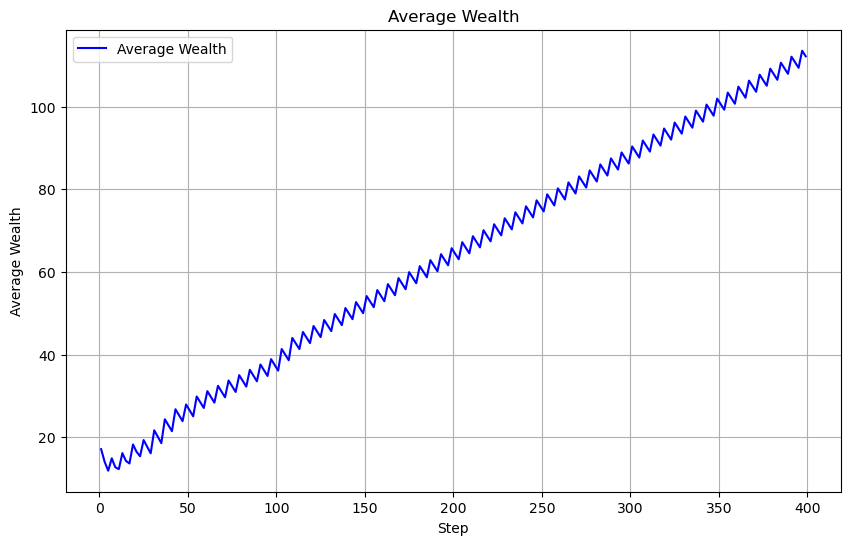

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(model_data["Step"], model_data["Average Wealth"], label="Average Wealth", color="blue")
plt.xlabel("Step")
plt.ylabel("Average Wealth")
plt.title("Average Wealth")
plt.legend()
plt.grid(True)
plt.show()

Survival plots

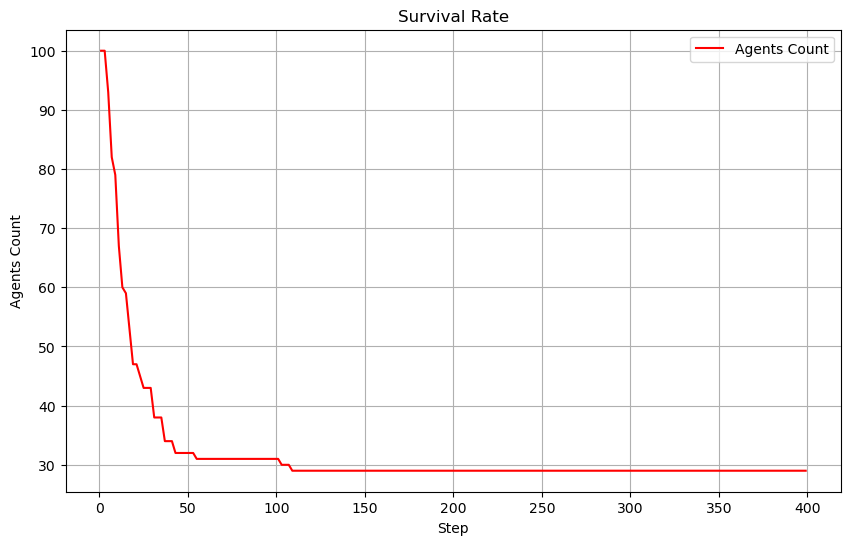

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(model_data["Step"], model_data["Agents"], label="Agents Count", color="red")
plt.xlabel("Step")
plt.ylabel("Agents Count")
plt.title("Survival Rate")
plt.legend()
plt.grid(True)
plt.show()

results = model1.run_linear_search(step_count=100, steal_amount_range=10, increment=1)
for steal_amount, dead_agents in results:
    print(f"Steal Amount: {steal_amount}, Dead Corrupt Agents: {dead_agents}")
#results = model1.run_model(100)

Wealth Plots

# Data collection

# Retrieve the data collected by the DataCollector
agent_data = model1.datacollector.get_agent_vars_dataframe()
mean_data = agent_data.groupby("Step").mean().reset_index()

#100th step data
step_100_data = agent_data.xs(100, level="Step")

#GroupBy bins in blocks of 100
bins = range(0, 210, 10)
step_100_data.loc[:, "Stolen Bins"] = pd.cut(step_100_data["Total Stolen"], bins=bins, right=False)
step_100_data.loc[:, "Eaten Bins"] = pd.cut(step_100_data["Total Eaten"], bins=bins, right=False)
step_100_data.loc[:, "Shared Bins"] = pd.cut(step_100_data["Total Shared"], bins=bins, right=False)

grouped_stolen = step_100_data.groupby("Stolen Bins")["Wealth"].mean().reset_index()
grouped_eaten = step_100_data.groupby("Eaten Bins")["Wealth"].mean().reset_index()
grouped_shared = step_100_data.groupby("Shared Bins")["Wealth"].mean().reset_index()

# Collection Efficiency vs Wealth
plt.figure(figsize=(10, 6))
sns.barplot(data=step_100_data, x="Collection Efficiency", y="Wealth")
plt.title('Collection Efficiency vs Wealth at Step 100')
#plt.show()
plt.savefig("Plots/corrupt_efficiency.png")

# Consumption vs Wealth
plt.figure(figsize=(10, 6))
sns.barplot(data=step_100_data, x="Consumption", y="Wealth")
plt.title('Consumption (Metabolism) vs Wealth at Step 100')
#plt.show()
plt.savefig("Plots/corrupt_consumption.png")

#Total Stolen vs Wealth
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_stolen, x="Stolen Bins", y="Wealth")
plt.title('Wealth vs Total Stolen')
plt.xlabel('Range Stolen')
plt.ylabel('Mean Wealth')
plt.xticks(rotation=45)
plt.tight_layout()
#plt.show()
plt.savefig("Plots/corrupt_totstolen.png")

#Total eat
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_eaten, x="Eaten Bins", y="Wealth")
plt.title('Wealth vs Total Eaten')
plt.xlabel('Total Eaten')
plt.ylabel('Mean Wealth')
plt.xticks(rotation=45)
plt.tight_layout()
#plt.show()
plt.savefig("Plots/corrupt_toteaten.png")

# Total Shared vs Wealth
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_shared, x="Shared Bins", y="Wealth")
plt.title('Wealth vs Total Shared')
plt.xlabel('Total Shared')
plt.ylabel('Mean Wealth')
plt.xticks(rotation=45)
plt.tight_layout()
#plt.show()
plt.savefig("Plots/corrupt_totshared.png")

Survival plots


agent_data.loc[:, "Stolen Bins"] = pd.cut(agent_data["Total Stolen"], bins=bins, right=False)
agent_data.loc[:, "Eaten Bins"] = pd.cut(agent_data["Total Eaten"], bins=bins, right=False)
agent_data.loc[:, "Shared Bins"] = pd.cut(agent_data["Total Shared"], bins=bins, right=False)

grouped_stolen = agent_data.groupby("Stolen Bins")["Survival"].mean().reset_index()
grouped_eaten = agent_data.groupby("Eaten Bins")["Survival"].mean().reset_index()
grouped_shared = agent_data.groupby("Shared Bins")["Survival"].mean().reset_index()

# Collection Efficiency vs Wealth
plt.figure(figsize=(10, 6))
sns.barplot(data=agent_data, x="Collection Efficiency", y="Survival")
plt.title('Collection Efficiency vs Survival')
#plt.show()
plt.savefig("Plots/Corrupt/Survival/corrupt_efficiency.png")

# Consumption vs Wealth
plt.figure(figsize=(10, 6))
sns.barplot(data=agent_data, x="Consumption", y="Survival")
plt.title('Consumption (Metabolism) vs Survival')
#plt.show()
plt.savefig("Plots/Corrupt/Survival/corrupt_consumption.png")

#Total Stolen vs Wealth
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_stolen, x="Stolen Bins", y="Survival")
plt.title('Survival vs Total Stolen')
plt.xlabel('Range Stolen')
plt.ylabel('Survival')
plt.xticks(rotation=45)
plt.tight_layout()
#plt.show()
plt.savefig("Plots/Corrupt/Survival/corrupt_totstolen.png")

#Total eat
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_eaten, x="Eaten Bins", y="Survival")
plt.title('Survival vs Total Eaten')
plt.xlabel('Total Eaten')
plt.ylabel('Survivial')
plt.xticks(rotation=45)
plt.tight_layout()
#plt.show()
plt.savefig("Plots/Corrupt/Survival/corrupt_toteaten.png")

# Total Shared vs Wealth
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_shared, x="Shared Bins", y="Survival")
plt.title('Survivla vs Total Shared')
plt.xlabel('Total Shared')
plt.ylabel('Survival')
plt.xticks(rotation=45)
plt.tight_layout()
#plt.show()
plt.savefig("Plots/Corrupt/Survival/corrupt_totshared.png")

In [11]:
# Check the unique steps available in the data
agent_data = model1.datacollector.get_agent_vars_dataframe()
available_steps = agent_data.index.get_level_values('Step').unique()
print("Available steps:", available_steps)


Available steps: Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       191, 192, 193, 194, 195, 196, 197, 198, 199, 200],
      dtype='int64', name='Step', length=200)


In [12]:
# Portrayal function for visualization
def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "r": 0.2}

    if isinstance(agent, Sugar):
        portrayal["Color"] = "green"
        portrayal["Layer"] = 0
        portrayal["r"] = agent.curr_amount / 30  # Scale size based on sugar amount
    elif isinstance(agent, Corrupt_agent):
        portrayal["Color"] = "red"
        portrayal["Layer"] = 1
        #portrayal["r"] = agent.sugar_agent / 30  # Scale size based on agent's sugar
        portrayal["text"] = str(agent.sugar_agent)  # Display the unique_id as text
        portrayal["text_color"] = "black"  # Set the color of the text

    return portrayal

agent_count_element = AgentCountElement()
average_wealth_element = AverageWealthElement()

# CanvasGrid for visualization
grid = CanvasGrid(agent_portrayal, 50, 50, 500, 500)

# ChartModule for visualizing data
chart = ChartModule([{"Label": "Share amount",
                      "Color": "Blue"},
                     {"Label": "Stolen Amount",
                      "Color": "Red"}],
                    data_collector_name='datacollector')

# Setting up the server
server = ModularServer(Model,
                       [grid, agent_count_element, average_wealth_element],
                       "Sugar Model",
                       {"X": 50, "Y": 50, "init_population": 100, "init_resource_min": 25, "init_resource_max": 50,
                        "metabolism_min": 1, "metabolism_max": 5, "vision_min": 1, "vision_max": 5, "seed": global_seed})
# Launch the server
server.port = 8521  # The default
server.launch()

Interface starting at http://127.0.0.1:8521


C:\Users\DELL\AppData\Local\Temp\ipykernel_10904\4154255263.py:4: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


AssertionError: 

Socket opened!
{"type":"reset"}


C:\Users\DELL\AppData\Local\Temp\ipykernel_10904\1091004614.py:13: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
